# GHONU pytorch models playground
place for testing the pytorch model

In [1]:
# Import libs

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from src import GHONU

## Create test data
Generate random sinus data for testing the HONN models.

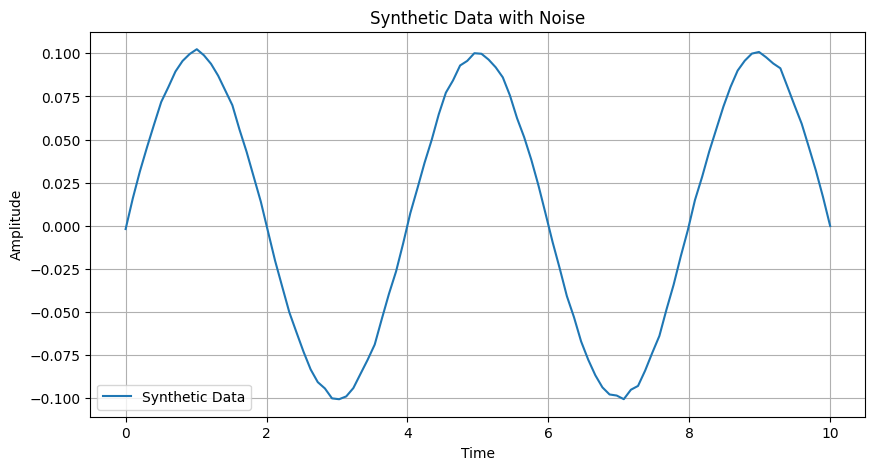

In [2]:
freqs = [0.25]
amps = [0.1, 0.2, 0.3]
phases = [0, 0.5, 1]
noise_lvl = 0.001
t_max = 10
n_samples = 100
t = np.linspace(0, t_max, n_samples)
# Generate synthetic data
signals = [
    amp * np.sin(2 * np.pi * freq * t + phase) for freq, amp, phase in zip(freqs, amps, phases)
]
noise = np.random.normal(0, noise_lvl, t.shape)
data = np.sum(signals, axis=0) + noise
# Plot the synthetic data
plt.figure(figsize=(10, 5))
plt.plot(t, data, label="Synthetic Data")
plt.title("Synthetic Data with Noise")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [3]:
# Prepare data for the models
N = data.shape[0]
prev_vals = 5  # Number of historical values to use
prediction_horizon = 1  # Predict two steps ahead

# Initialize X and y
X = np.zeros((N - prev_vals - prediction_horizon + 1, prev_vals))
y = np.zeros((N - prev_vals - prediction_horizon + 1, 1))

# Create historical values and targets
for i in range(prev_vals, N - prediction_horizon + 1):
    X[i - prev_vals] = data[i - prev_vals : i][::-1]  # Reverse to maintain chronological order
    y[i - prev_vals] = data[
        i + prediction_horizon - 1
    ]  # Target is `prediction_horizon` steps ahead

# Normalize the data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Data shape: {data.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
# Print the first 3 train/test pairs
print("First 3 training pairs:")
for i in range(3):
    print(f"X_train[{i}]: {X_train[i]}, y_train[{i}]: {y_train[i]}")

Data shape: (100,)
X_train shape: (76, 5), y_train shape: (76, 1)
X_test shape: (19, 5), y_test shape: (19, 1)
First 3 training pairs:
X_train[0]: [0.78534102 0.71968002 0.6506148  0.57317648 0.48621302], y_train[0]: [0.84930602]
X_train[1]: [0.84930602 0.78534102 0.71968002 0.6506148  0.57317648], y_train[1]: [0.89160755]
X_train[2]: [0.89160755 0.84930602 0.78534102 0.71968002 0.6506148 ], y_train[2]: [0.93627234]


In [4]:
# Train the HONU model
input_shape = X.shape[1]
predictor_order = 3
gate_order = 3
gate_activation = "sigmoid"
bias = True

lr_p = 0.01
lr_g = 0.001
batch_size = 10
epochs = 175

model = GHONU(input_shape, predictor_order, gate_order, gate_activation=gate_activation, bias=bias)
optimizer = torch.optim.Adam(
    [
        {"params": model.predictor.parameters(), "lr": lr_p},
        {"params": model.gate.parameters(),      "lr": lr_g},
    ]
)
loss_fn = torch.nn.MSELoss()

# Convert data to PyTorch tensors and add batch dimension
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training loop
loss_history_train = np.zeros(epochs)  # To store average loss for each epoch
loss_history_test = np.zeros(epochs)  # To store average loss for each epoch
for epoch in tqdm(range(epochs), desc="Training Progress"):
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i : i + batch_size]
        input_batch, target_batch = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = loss_fn(outputs, target_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / (X_train_tensor.size(0) // batch_size)
    loss_history_train[epoch] = avg_loss  # Save the average loss for this epoch

    # Test the model on the test set
    epoch_loss_test = 0.0
    for i in range(0, X_test_tensor.size(0), batch_size):
        input_batch, target_batch = (
            X_test_tensor[i : i + batch_size],
            y_test_tensor[i : i + batch_size],
        )

        with torch.no_grad():
            outputs = model(input_batch)
            loss = loss_fn(outputs, target_batch)
            epoch_loss_test += loss.item()

    avg_loss_test = epoch_loss_test / (X_test_tensor.size(0) // batch_size)
    loss_history_test[epoch] = avg_loss_test  # Save the average loss for this epoch

# Print the achieved training loss
print(f"Achieved Training Loss: {loss_history_train[-1]:.6f}")
# Print the achieved testing loss
print(f"Achieved Testing Loss: {loss_history_test[-1]:.6f}")


Training Progress: 100%|██████████| 175/175 [00:00<00:00, 223.59it/s]

Achieved Training Loss: 0.000312
Achieved Testing Loss: 0.000419


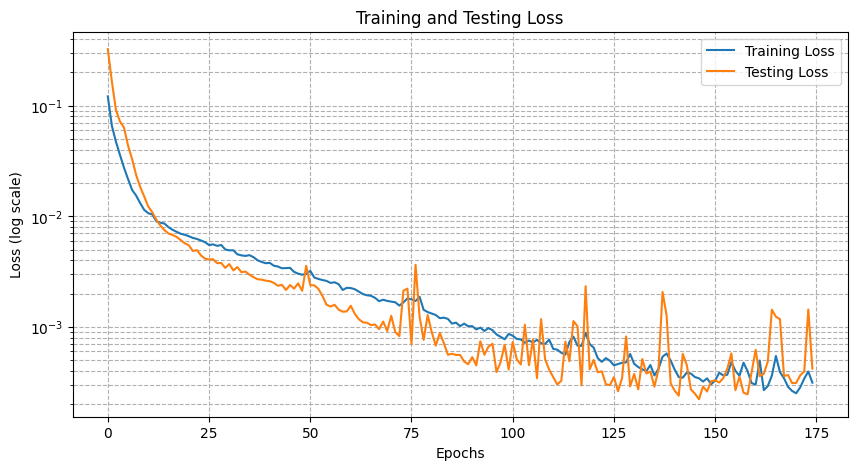

In [5]:
# Show training and testing loss on a log scale
plt.figure(figsize=(10, 5))
plt.plot(loss_history_train, label="Training Loss")
plt.plot(loss_history_test, label="Testing Loss")
plt.yscale("log")  # set y-axis to logarithmic scale
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.grid(which="both", ls="--")
plt.show()

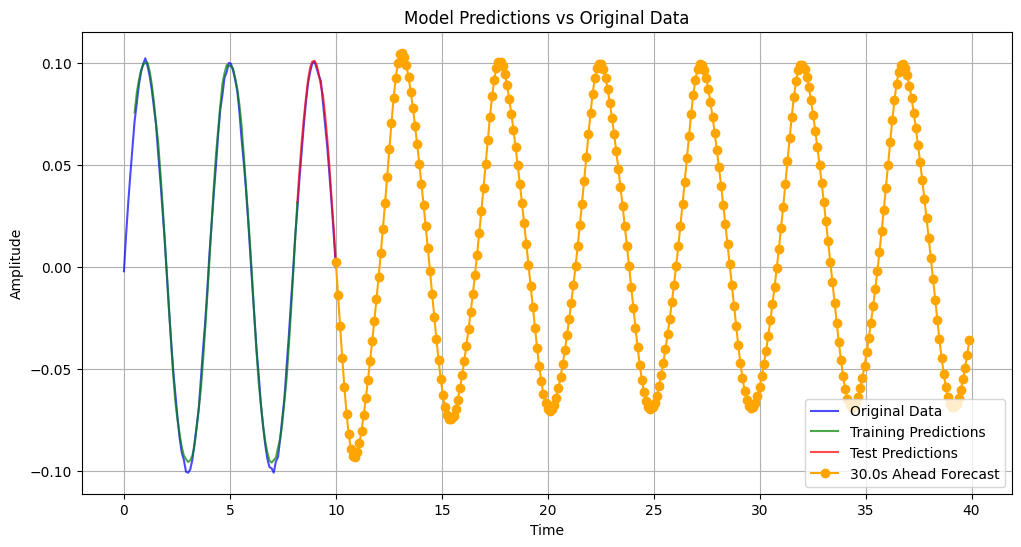

In [6]:
# Visualize model predictions
plt.figure(figsize=(12, 6))

# Original data
plt.plot(t, data, label="Original Data", color="blue", alpha=0.7)

# Model predictions on training data
train_predictions = model(X_train_tensor).detach().numpy()
train_predictions = scaler_y.inverse_transform(train_predictions)
# shift by prev_vals + (prediction_horizon - 1)
train_time = t[
    prev_vals + prediction_horizon - 1 : prev_vals + prediction_horizon - 1 + len(train_predictions)
]
plt.plot(train_time, train_predictions, label="Training Predictions", color="green", alpha=0.7)

# Model predictions on test data
test_predictions = model(X_test_tensor).detach().numpy()
test_predictions = scaler_y.inverse_transform(test_predictions)
# start after the end of train predictions, also shifted
test_time = t[
    prev_vals + prediction_horizon - 1 + len(train_predictions) : prev_vals
    + prediction_horizon
    - 1
    + len(train_predictions)
    + len(test_predictions)
]
plt.plot(test_time, test_predictions, label="Test Predictions", color="red", alpha=0.7)

# Connect last train point to first test point
if len(train_predictions) and len(test_predictions):
    plt.plot(
        [train_time[-1], test_time[0]],
        [train_predictions[-1], test_predictions[0]],
        color="green",
        alpha=0.7,
    )

# --- Multi‐step forecast beyond end of data (1 second ahead) ---
dt = t[1] - t[0]
t_ahead = 30.0
n_future = int(t_ahead / dt)

# start from last test‐window (normalized)
window = X_test_tensor[-1].clone().squeeze()
future_norm = []

model.eval()
with torch.no_grad():
    for _ in range(n_future):
        pred = model(window.unsqueeze(0)).squeeze()
        future_norm.append(pred.item())
        window = torch.cat([pred.unsqueeze(0), window[:-1]])

# back to original scale
future_preds = scaler_y.inverse_transform(np.array(future_norm).reshape(-1, 1)).flatten()

# build future time axis (exactly n_future steps)
future_times = test_time[-1] + np.arange(0, n_future) * dt


plt.plot(future_times, future_preds, color="orange", marker="o", label=f"{t_ahead}s Ahead Forecast")

# Plot settings
plt.title("Model Predictions vs Original Data")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [7]:
for name, param in model.named_parameters():
    print(name, param.size())

predictor.weight torch.Size([56])
gate.weight torch.Size([56])


In [8]:
print(model)

GHONU(
  in_features=5, 
  predictor=HONU(in_features=5, polynomial_order=3, bias=True, activation=identity),
  gate=HONU(in_features=5, polynomial_order=3, bias=True, activation=sigmoid)
)


In [10]:
model.gate.weight

Parameter containing:
tensor([ 5.3726e-03, -3.5731e-02, -4.7626e-02, -5.2850e-02, -5.7794e-02,
        -6.4969e-02, -4.7938e-02, -4.6018e-02, -4.3544e-02, -3.9907e-02,
        -3.9294e-02, -4.1698e-02, -4.2823e-02, -3.8851e-02, -3.2813e-02,
        -3.4332e-02, -3.4204e-02, -3.3897e-02, -3.2356e-02, -3.1200e-02,
        -2.9557e-02, -2.9054e-02, -2.9238e-02, -2.2986e-02, -1.4320e-02,
        -5.6507e-03, -2.5268e-02, -1.9445e-02, -6.7589e-03, -5.7604e-03,
        -1.3752e-02, -9.7048e-03, -4.1506e-03,  1.1128e-03,  1.6812e-04,
         3.7785e-03, -1.0584e-02, -1.5161e-02, -5.0982e-03, -8.2277e-04,
        -3.5905e-03, -3.8926e-03,  8.8217e-04,  3.9561e-03,  1.8007e-03,
         6.2475e-03,  3.7463e-04, -3.0274e-03,  4.8208e-03, -1.5715e-03,
         4.8823e-03,  6.2765e-05,  1.3485e-03,  1.7007e-03,  7.4926e-03,
         4.8306e-03], requires_grad=True)

In [11]:
print(list(model.parameters()))

[Parameter containing:
tensor([ 0.1120,  1.2059,  0.8029,  0.3558, -0.1343, -0.6613,  0.3376,  0.2303,
         0.1360,  0.0502, -0.0052,  0.1474,  0.0724,  0.0020, -0.0583,  0.0022,
        -0.0647, -0.1105, -0.1189, -0.1739, -0.2358,  0.0797,  0.0694,  0.0626,
         0.0520,  0.0562,  0.0655,  0.0604,  0.0522,  0.0582,  0.0522,  0.0436,
         0.0536,  0.0486,  0.0556,  0.0580,  0.0539,  0.0560,  0.0436,  0.0482,
         0.0502,  0.0423,  0.0472,  0.0357,  0.0432,  0.0404,  0.0453,  0.0426,
         0.0391,  0.0309,  0.0324,  0.0289,  0.0204,  0.0104,  0.0054, -0.0078],
       requires_grad=True), Parameter containing:
tensor([ 5.3726e-03, -3.5731e-02, -4.7626e-02, -5.2850e-02, -5.7794e-02,
        -6.4969e-02, -4.7938e-02, -4.6018e-02, -4.3544e-02, -3.9907e-02,
        -3.9294e-02, -4.1698e-02, -4.2823e-02, -3.8851e-02, -3.2813e-02,
        -3.4332e-02, -3.4204e-02, -3.3897e-02, -3.2356e-02, -3.1200e-02,
        -2.9557e-02, -2.9054e-02, -2.9238e-02, -2.2986e-02, -1.4320e-02,
 

In [12]:
for name, param in model.named_parameters():
    print(name, param)

predictor.weight Parameter containing:
tensor([ 0.1120,  1.2059,  0.8029,  0.3558, -0.1343, -0.6613,  0.3376,  0.2303,
         0.1360,  0.0502, -0.0052,  0.1474,  0.0724,  0.0020, -0.0583,  0.0022,
        -0.0647, -0.1105, -0.1189, -0.1739, -0.2358,  0.0797,  0.0694,  0.0626,
         0.0520,  0.0562,  0.0655,  0.0604,  0.0522,  0.0582,  0.0522,  0.0436,
         0.0536,  0.0486,  0.0556,  0.0580,  0.0539,  0.0560,  0.0436,  0.0482,
         0.0502,  0.0423,  0.0472,  0.0357,  0.0432,  0.0404,  0.0453,  0.0426,
         0.0391,  0.0309,  0.0324,  0.0289,  0.0204,  0.0104,  0.0054, -0.0078],
       requires_grad=True)
gate.weight Parameter containing:
tensor([ 5.3726e-03, -3.5731e-02, -4.7626e-02, -5.2850e-02, -5.7794e-02,
        -6.4969e-02, -4.7938e-02, -4.6018e-02, -4.3544e-02, -3.9907e-02,
        -3.9294e-02, -4.1698e-02, -4.2823e-02, -3.8851e-02, -3.2813e-02,
        -3.4332e-02, -3.4204e-02, -3.3897e-02, -3.2356e-02, -3.1200e-02,
        -2.9557e-02, -2.9054e-02, -2.9238e-02, 